# Tech Challenge – Detecção de Tuberculose em Radiografias de Tórax

## Contexto
Este notebook implementa um sistema de apoio à triagem clínica usando IA.  
Objetivo: classificar radiografias de tórax como **Tuberculose** (doente) ou **Normal** (saudável).  
Isso atende ao requisito do Tech Challenge de criar um modelo de machine learning capaz de dizer se uma pessoa tem ou não uma doença, usando dados médicos reais.

> ⚠ Uso exclusivamente acadêmico. O diagnóstico médico final deve ser sempre feito por um profissional de saúde. Este modelo **não é** um dispositivo médico homologado.


## 1. Ambiente e Dependências
- Instala dependências necessárias (TensorFlow, scikit-learn, grad-cam).

In [48]:
import os, sys, numpy as np, matplotlib.pyplot as plt
import cv2
import kagglehub
from pathlib import Path
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model, Input, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore


## 2. Carregar e Organizar o Dataset

O dataset contém radiografias de tórax rotuladas como **Normal** e **Tuberculosis** (tuberculose confirmada).  
Nós vamos copiar as imagens do Google Drive para `/content/data/normal` e `/content/data/tuberculosis`.


In [37]:


# ============================================
# 1. Baixar dataset via KaggleHub
# ============================================
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")
print("📦 Dataset baixado em:", path)

# Caminho base do dataset baixado
source_path = Path(path) / "TB_Chest_Radiography_Database"

# ============================================
# 2. Definir diretórios que já existem no dataset
# ============================================
NORMAL_DIR = source_path / "Normal"
TB_DIR = source_path / "Tuberculosis"

# Verificar se as pastas existem
print(f"\n📂 Verificando pastas do dataset:")
print(f"  Normal existe: {NORMAL_DIR.exists()}")
print(f"  Tuberculosis existe: {TB_DIR.exists()}")

# ============================================
# 3. Usar o diretório source_path como DATA_DIR
# ============================================
DATA_DIR = source_path

# ============================================
# 4. Contar imagens válidas
# ============================================
valid_ext = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

def count_images(directory):
    """Conta imagens válidas em um diretório"""
    count = 0
    if directory.exists():
        for f in directory.iterdir():
            if f.is_file() and f.suffix.lower() in valid_ext:
                count += 1
    return count

num_normal = count_images(NORMAL_DIR)
num_tb = count_images(TB_DIR)

# ============================================
# 5. Exibir resultados
# ============================================
print(f"\n✅ Imagens Normal encontradas: {num_normal}")
print(f"✅ Imagens Tuberculosis encontradas: {num_tb}")
print(f"✅ Total de imagens: {num_normal + num_tb}")

print("\n📂 Estrutura do diretório do dataset:")
for p in DATA_DIR.glob('*'):
    if p.is_dir():  # Filtrar apenas diretórios
        img_count = count_images(p)
        print(f" - {p.name}: {img_count} imagens")


📦 Dataset baixado em: C:\Users\felip\.cache\kagglehub\datasets\tawsifurrahman\tuberculosis-tb-chest-xray-dataset\versions\3

📂 Verificando pastas do dataset:
  Normal existe: True
  Tuberculosis existe: True

✅ Imagens Normal encontradas: 3500
✅ Imagens Tuberculosis encontradas: 700
✅ Total de imagens: 4200

📂 Estrutura do diretório do dataset:
 - Normal: 3500 imagens
 - Tuberculosis: 700 imagens


## 3. Sanity Check de Integridade

Requisito do Tech Challenge: limpar dados e garantir consistência.

- Tentar abrir cada imagem do dataset
- Detectar arquivos corrompidos / vazios
- Remover imagens problemáticas, se houver

In [38]:
from PIL import Image
import numpy as np

invalid_images = []

for img_path in DATA_DIR.rglob('*'):
    if img_path.suffix.lower() in valid_ext:
        try:
            img = Image.open(img_path)
            img.verify()  # teste de corrupção
            img = Image.open(img_path).convert("RGB")
            arr = np.array(img)
            if arr.std() == 0:
                invalid_images.append((str(img_path), "imagem uniforme/vazia"))
        except Exception as e:
            invalid_images.append((str(img_path), f'erro: {e}'))

print('Total suspeitas/corrompidas:', len(invalid_images))
if invalid_images[:5]:
    for p,e in invalid_images[:5]:
        print('-', p, '->', e)

# Remover imagens inválidas (se houver)
for p,_ in invalid_images:
    try:
        os.remove(p)
    except:
        pass


Total suspeitas/corrompidas: 0


**Conclusão do sanity check:**  
Garantimos que o modelo não será treinado com imagens corrompidas ou vazias. Isso atende à parte de *"limpeza de dados"* exigida.


## 4. Carregamento Estruturado, Split Treino/Val, e EDA

Agora vamos:
1. Criar geradores de treino/validação usando `ImageDataGenerator` com augmentation.
2. Fazer um split estratificado (validation_split=0.2).
3. Explorar distribuição de classes e visualizar amostras.

Isso cobre a parte de **Exploração de Dados (EDA)** do Tech Challenge.


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Classes: {'Normal': 0, 'Tuberculosis': 1}
Total treino: 3360
Total val: 840
Distribuição treino (0=Normal,1=TB): {np.int32(0): np.int64(2800), np.int32(1): np.int64(560)}
Classes: {'Normal': 0, 'Tuberculosis': 1}
Total treino: 3360
Total val: 840
Distribuição treino (0=Normal,1=TB): {np.int32(0): np.int64(2800), np.int32(1): np.int64(560)}


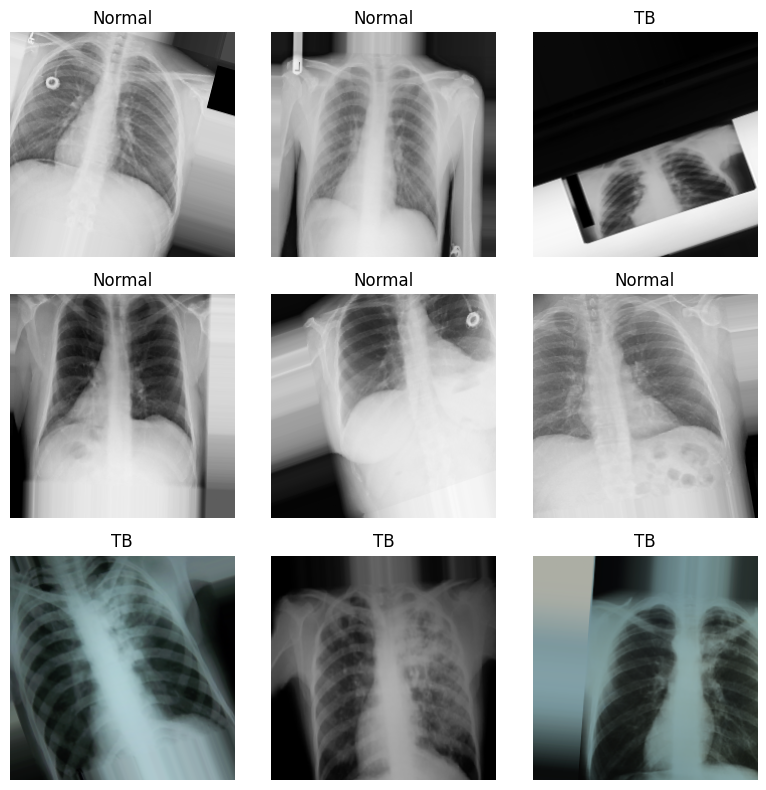

In [39]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    validation_split=0.2,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print('Classes:', train_generator.class_indices)
print('Total treino:', train_generator.samples)
print('Total val:', val_generator.samples)

# Distribuição de classes no treino
labels, counts = np.unique(train_generator.classes, return_counts=True)
print('Distribuição treino (0=Normal,1=TB):', dict(zip(labels, counts)))

# Visualizar algumas imagens
images_batch, labels_batch = next(train_generator)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images_batch[i])
    plt.title('TB' if labels_batch[i]==1 else 'Normal')
    plt.axis('off')
plt.tight_layout()
plt.show()


**Análise EDA:**  
- Vemos quantas imagens há em cada classe. Se a classe 'tuberculosis' tiver bem menos exemplos, o dataset está desbalanceado.  
- Observando amostras, percebemos diferenças visuais (opacidades pulmonares, infiltrados).  
- Isso atende à exigência de explorar características e discutir distribuição dos dados.


## 5. Modelo 1: CNN Convolucional Simples (baseline)

Primeira técnica de modelagem exigida: construir um classificador usando CNN criada manualmente.


In [40]:
baseline_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3), #Dropout "desliga" aleatoriamente 30% dos neurônios daquela camada. Isso força o modelo a não decorar o conjunto de treino e reduz overfitting.
    Dense(1, activation='sigmoid')
])

baseline_model.summary()

test_datagen = ImageDataGenerator(rescale=1./255) # Only rescaling needed for test data

test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation', # Use the validation subset for testing as per the instructions
    shuffle=False
)

print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")


baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.Precision(name='prec'),
        keras.metrics.Recall(name='rec')
    ]
)

# acc (acurácia binária)
# prec (precisão / precision)
# rec (revocação / recall / sensibilidade)
# 👉 Por que isso importa muito no seu caso (tuberculose / diagnóstico médico)?
# Recall (sensibilidade) responde: "de todos os pacientes DOENTES, quantos eu marquei como doentes?"
# Baixo recall = falso negativo = você deixou passar um doente. Isso é o cenário mais perigoso.
# Precision responde: "quando eu digo que a pessoa está doente, eu realmente estou certo?"
# Baixa precisão = falso positivo = gerar alarme à toa. Ruim, mas menos crítico que falso negativo pro triagem inicial.



history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15, # Training for 15 epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)


c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Found 0 images belonging to 2 classes.


c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 0 test images belonging to 2 classes.
Epoch 1/15
Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 420ms/step - acc: 0.8824 - loss: 0.4039 - prec: 0.9275 - rec: 0.3196 - val_acc: 0.8534 - val_loss: 0.3698 - val_prec: 0.9167 - val_rec: 0.0833
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 420ms/step - acc: 0.8824 - loss: 0.4039 - prec: 0.9275 - rec: 0.3196 - val_acc: 0.8534 - val_loss: 0.3698 - val_prec: 0.9167 - val_rec: 0.0833
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 476ms/step - acc: 0.9122 - loss: 0.2425 - prec: 0.9316 - rec: 0.5107 - val_acc: 0.8606 - val_loss: 0.9779 - val_prec: 1.0000 - val_rec: 0.1212
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 476ms/step - acc: 0.9122 - loss: 0.2425 - prec: 0.9316 - rec: 0.5107 - val_acc: 0.8606 - val_loss: 0.9779 - val_prec: 1.0000 - val_rec: 0.1212
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - acc: 0.9217 - loss: 0.2076 - prec: 0.9183 - rec: 0.5821 - val_acc: 0.8702 - val_loss: 0.2458 - val_prec: 0.9000 - val_rec: 0.2045
Epoch 4/15

## 6. Modelo 2: Transfer Learning (MobileNetV2)

Segunda técnica exigida: um modelo diferente.  
Aqui usamos MobileNetV2 pré-treinada em ImageNet como extrator de features.


In [41]:


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # primeira fase: congelado

inputs = Input(shape=(224,224,3))
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

transfer_model = Model(inputs, outputs)

transfer_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.Precision(name='prec'),
        keras.metrics.Recall(name='rec')
    ]
)

transfer_model.summary()

history_transfer = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Fine-tuning leve (descongela últimas camadas)
for layer in base_model.layers[-40:]:
    layer.trainable = True

transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc'),
        keras.metrics.Precision(name='prec'),
        keras.metrics.Recall(name='rec')
    ]
)

history_transfer_ft = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 52s 467ms/step - acc: 0.8173 - loss: 0.4984 - prec: 0.2188 - rec: 0.0375 - val_acc: 0.8333 - val_loss: 0.4617 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 52s 467ms/step - acc: 0.8173 - loss: 0.4984 - prec: 0.2188 - rec: 0.0375 - val_acc: 0.8333 - val_loss: 0.4617 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 453ms/step - acc: 0.8298 - loss: 0.4769 - prec: 0.0714 - rec: 0.0018 - val_acc: 0.8333 - val_loss: 0.4577 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 453ms/step - acc: 0.8298 - loss: 0.4769 - prec: 0.0714 - rec: 0.0018 - val_acc: 0.8333 - val_loss: 0.4577 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 467ms/step - acc: 0.8324 - loss: 0.4722 - prec: 0.2000 - rec: 0.0018 - val_acc: 0.8333 - val_loss: 0.4507 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 4/10
105/105 ━━━━━━

## 7. Avaliação Final: Accuracy, Precision, Recall, F1-score e Matriz de Confusão

Requisito do Tech Challenge: avaliar com métricas adequadas (accuracy, recall, F1-score), justificar a métrica escolhida e analisar se o modelo pode ser usado na prática.


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step
Accuracy: 0.8333333333333334
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Classification Report:
               precision    recall  f1-score   support

      Normal       0.83      1.00      0.91       700
Tuberculosis       0.00      0.00      0.00       140

    accuracy                           0.83       840
   macro avg       0.42      0.50      0.45       840
weighted avg       0.69      0.83      0.76       840

Accuracy: 0.8333333333333334
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Classification Report:
               precision    recall  f1-score   support

      Normal       0.83      1.00      0.91       700
Tuberculosis       0.00      0.00      0.00       140

    accuracy                           0.83       840
   macro avg       0.42      0.50      0.45       840
weighted avg       0.69      0.83      0.76       840



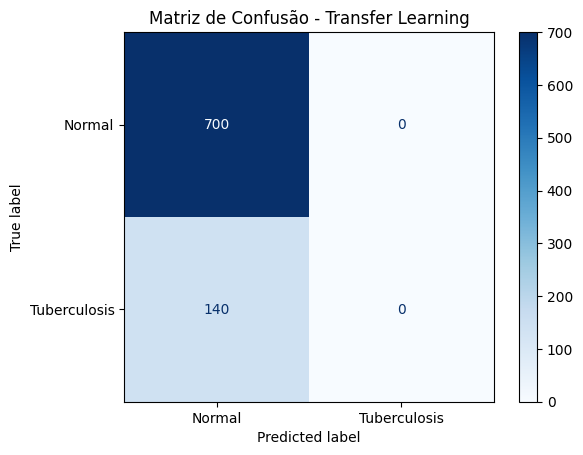

In [42]:
# Avaliar o melhor modelo (transfer_model após fine-tuning)
y_true = val_generator.classes
y_prob = transfer_model.predict(val_generator)
y_pred = (y_prob >= 0.5).astype(int).ravel()

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
cm   = confusion_matrix(y_true, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Normal','Tuberculosis'], zero_division=0))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Tuberculosis'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Transfer Learning")
plt.show()


**Discussão de Métricas:**  
- **Recall** é a métrica crítica na detecção de doenças infecciosas:  
  - Recall alto = poucos falsos negativos (casos de tuberculose que o modelo perdeu).  
  - Falso negativo é muito perigoso, pois pode atrasar isolamento/tratamento e aumentar risco de transmissão.  
- **F1-score** equilibra precisão e recall quando as classes são desbalanceadas.


## 8. Interpretabilidade (Grad-CAM++)

O enunciado pede algo equivalente a *feature importance / SHAP*.  
Para imagens médicas, usamos **Grad-CAM++** para ver ONDE o modelo olhou na radiografia.

Isso também cobre a parte de "análise de correlação" entre padrões visuais e classe prevista.


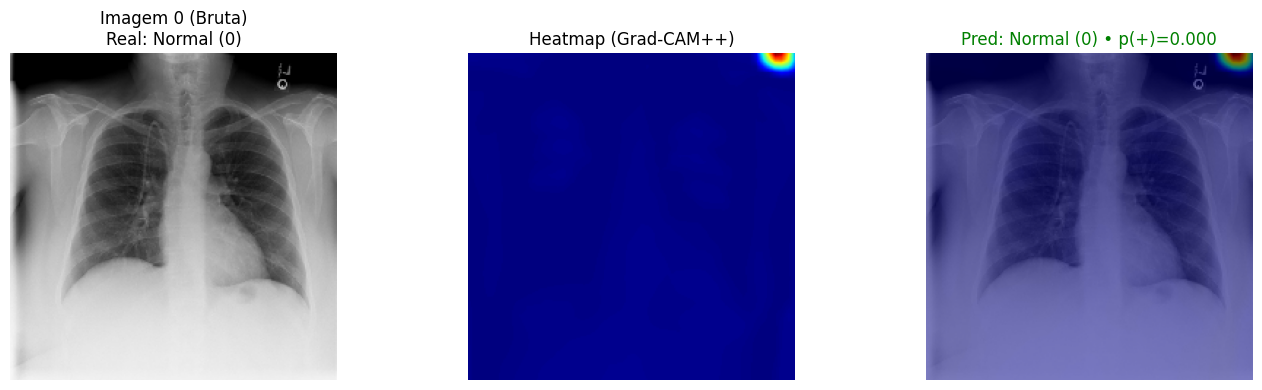

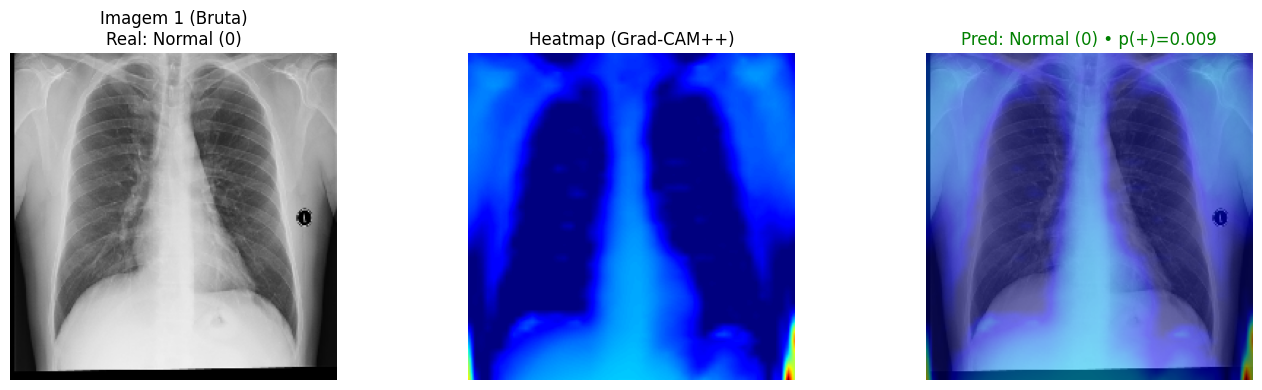

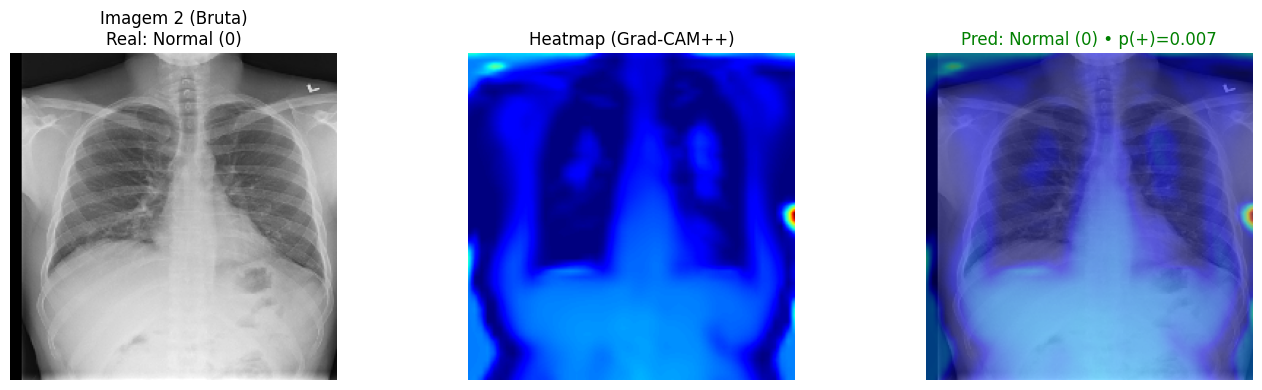

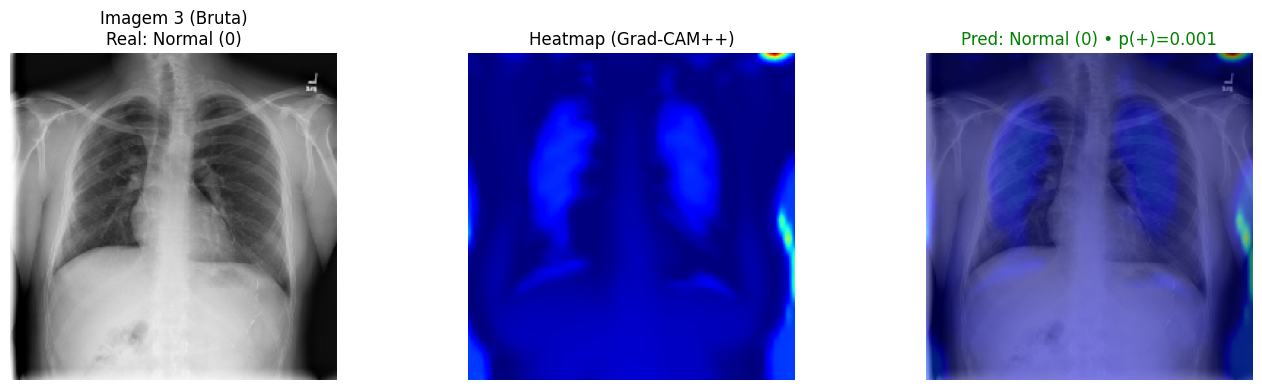

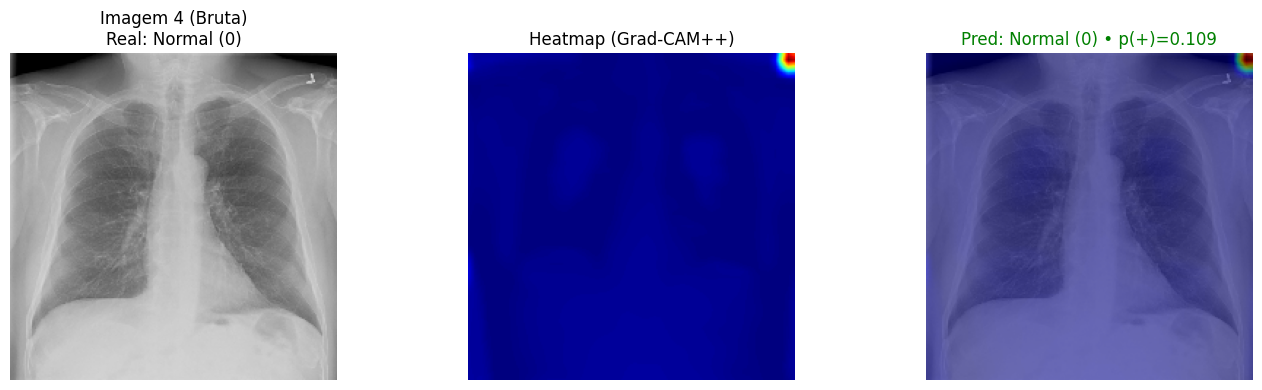

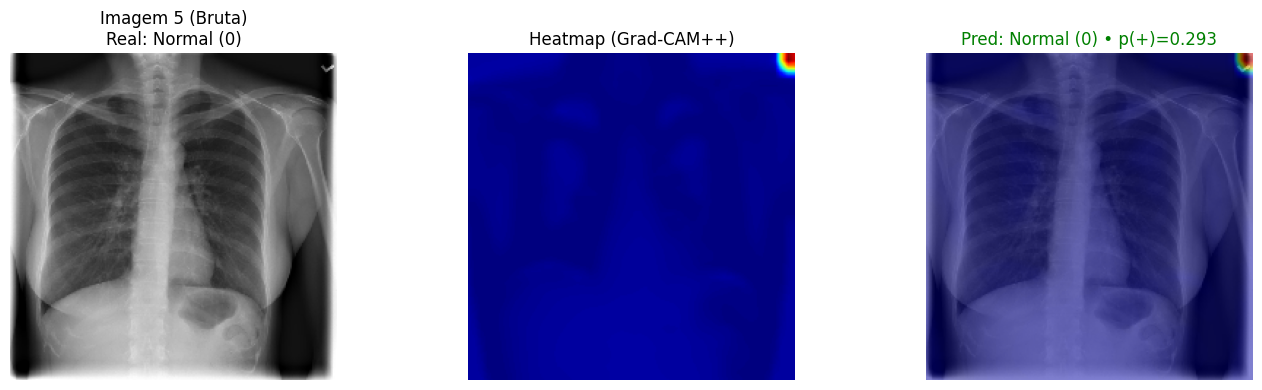

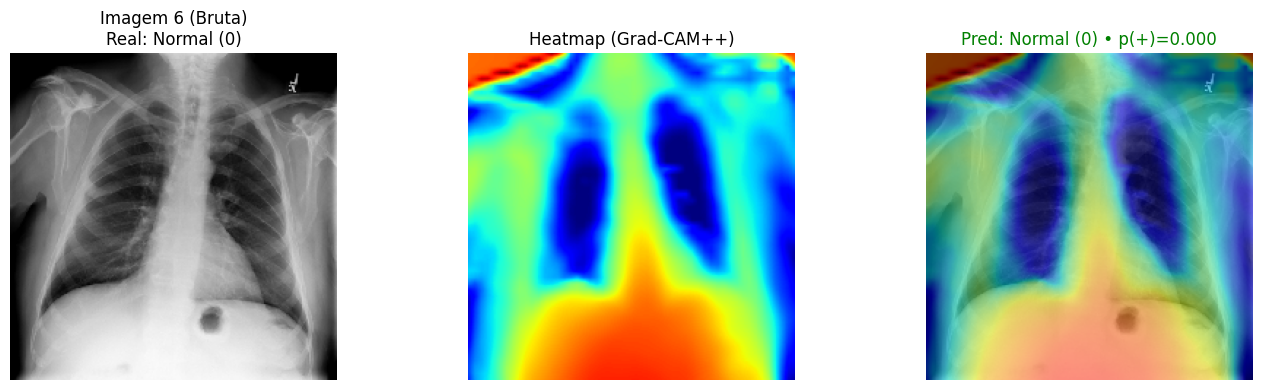

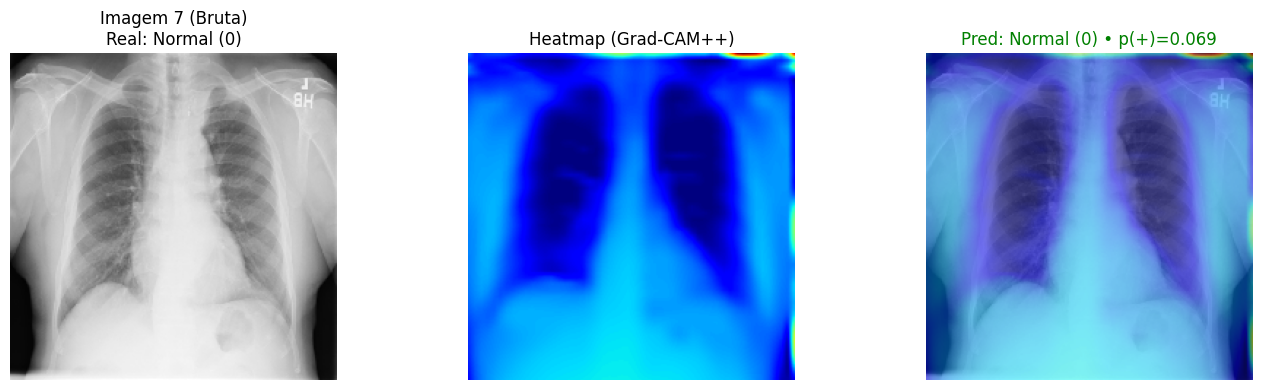

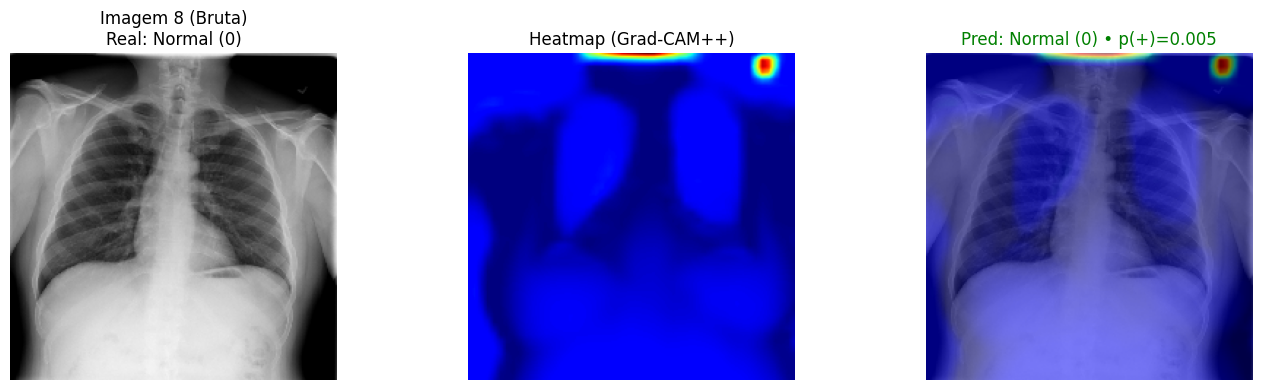

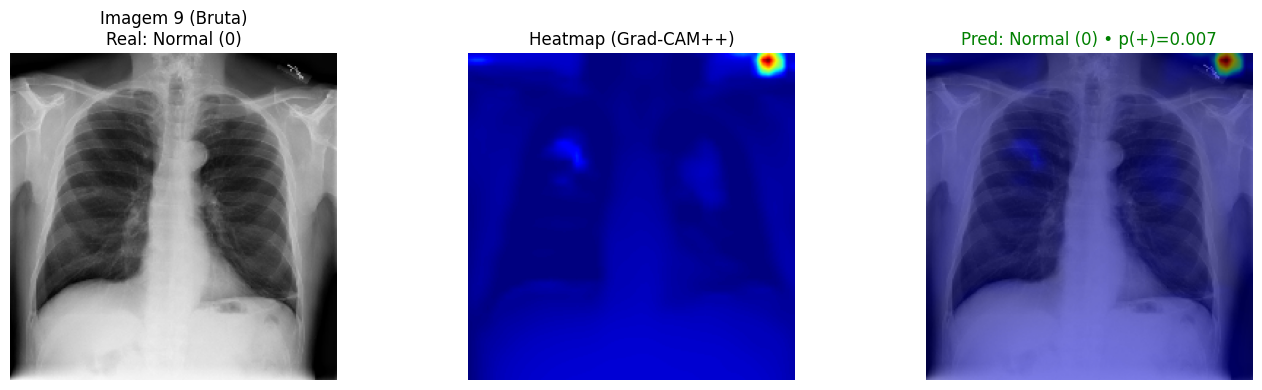

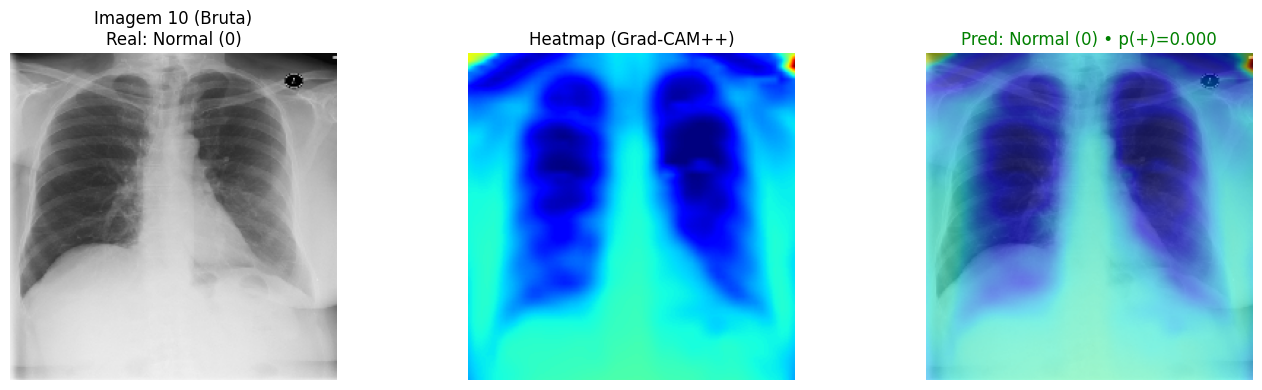

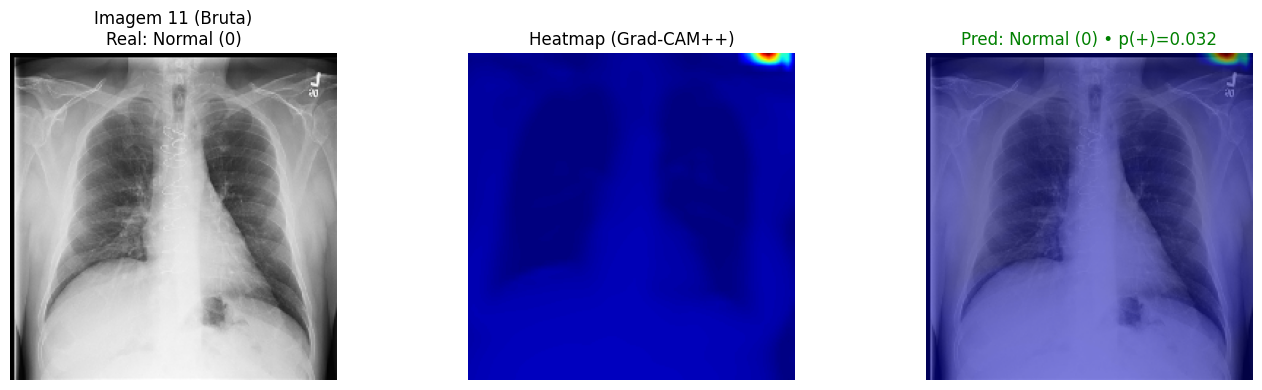

In [58]:
# ===================== Visualização RICA: Bruta | Heatmap | Overlay =====================
import os, cv2, numpy as np, matplotlib.pyplot as plt, matplotlib.cm as mpl_cm
import tensorflow as tf
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import BinaryScore

# ======= Parâmetros =======
POS_IDX = 1                 # classe positiva (Tuberculosis)
THRESH = 0.5                # limiar para probabilidade positiva
N_VIS = 12                  # máximo de amostras exibidas
SHOW_ONLY_FN = False        # True = mostrar apenas falsos negativos

# ======= Batch de validação =======
images, labels = next(val_generator)        # (B,H,W,C) em [0,1] por conta do rescale
labels = labels.astype(int).ravel()         # binário (0/1)

# ======= Predições =======
probs = baseline_model.predict(images, verbose=0).ravel()     # saída sigmoid
preds = (probs >= THRESH).astype(int)

# ======= Mapeamento de nomes =======
try:
    idx2name = {v:k for k,v in val_generator.class_indices.items()}  # {0:'Normal', 1:'Tuberculosis'}
except:
    idx2name = {0:'Class 0', 1:'Class 1'}

true_names = [idx2name.get(int(y), str(int(y))) for y in labels]
pred_names = [idx2name.get(int(p), str(int(p))) for p in preds]

# ======= Seleção das amostras a exibir =======
idxs = np.arange(len(images))

if SHOW_ONLY_FN:
    # Falso Negativo: y=1 (positivo) mas modelo previu 0
    mask_fn = (labels == POS_IDX) & (preds != POS_IDX)
    idxs = idxs[mask_fn]
else:
    idxs = idxs  # todas

if len(idxs) == 0:
    print("Nenhuma amostra correspondente ao filtro. Ajuste SHOW_ONLY_FN ou pegue novo batch do val_generator.")
else:
    idxs = idxs[:N_VIS]

# ======= Gera Grad-CAM++ se necessário =======
try:
    _ = cam.shape
    has_cam = (len(cam) >= len(images))
except:
    has_cam = False

if not has_cam:
    # detectar última Conv2D do baseline_model
    conv_layers = [layer for layer in baseline_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    assert len(conv_layers) > 0, "Modelo não possui Conv2D."
    last_conv_layer_name = conv_layers[-1].name

    gradcam = GradcamPlusPlus(baseline_model, clone=True)  # sem model_modifier para evitar incompatibilidades
    loss = BinaryScore(POS_IDX)
    cam = gradcam(loss, images, penultimate_layer=last_conv_layer_name)
    cam = normalize(cam)

# ======= Utilitário =======
def to_rgb(img):
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    elif img.ndim == 3 and img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    return img

# ======= Plot enriquecido =======
for i in idxs:
    img = to_rgb(images[i])                      # (H,W,3) em [0,1]
    h, w = img.shape[:2]

    heat = cam[i]
    heat = np.nan_to_num(heat, nan=0.0)
    heat = cv2.resize(heat, (w, h))
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

    heatmap = np.uint8(mpl_cm.jet(heat)[..., :3] * 255)
    base_uint8 = np.uint8(np.clip(img * 255.0, 0, 255))
    overlay = cv2.addWeighted(base_uint8, 0.5, heatmap, 0.5, 0)

    # títulos ricos
    y_true = labels[i]
    y_pred = preds[i]
    p = float(probs[i])
    correct = (y_true == y_pred)

    title_color = "green" if correct else "red"
    true_txt = f"Real: {true_names[i]} ({y_true})"
    pred_txt = f"Pred: {pred_names[i]} ({y_pred}) • p(+)={p:.3f}"

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].imshow(img)
    axs[0].set_title(f"Imagem {i} (Bruta)\n{true_txt}", color="black")
    axs[0].axis("off")

    axs[1].imshow(heatmap)
    axs[1].set_title("Heatmap (Grad-CAM++)", color="black")
    axs[1].axis("off")

    axs[2].imshow(overlay)
    axs[2].set_title(f"{pred_txt}", color=title_color)
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


## 9. Conclusões, Limitações e Uso Clínico

### Limitações
- O dataset vem de uma única fonte. Pode não generalizar para outros hospitais, aparelhos de raio-X ou populações.  
- Ainda há risco de **falsos negativos** (paciente com TB classificado como Normal).  
- O modelo não diferencia estágio ou gravidade da tuberculose. Ele só responde "normal" vs "tuberculose".

### Uso na prática
Este modelo pode atuar como **ferramenta de triagem inicial**: sinalizar exames potencialmente positivos para priorizar revisão médica rápida.  
Ele **não substitui** o laudo médico oficial.

### Alinhamento com o Tech Challenge
Este notebook entrega:
- Limpeza de dados e sanity check;
- EDA e análise de distribuição;
- Pipeline de pré-processamento (resize, normalização, augmentation);
- Dois modelos de classificação (CNN simples e Transfer Learning);
- Separação treino/validação;
- Métricas (accuracy, precision, recall, F1-score) + matriz de confusão;
- Justificativa da métrica principal (recall);
- Interpretabilidade com Grad-CAM++;
- Discussão crítica sobre uso real e limites éticos.

Para fechar a entrega formal:
1. Publique este notebook no GitHub junto com um README.md e um Dockerfile.
2. No PDF entregue na avaliação inclua:
   - link do repositório,
   - prints das métricas,
   - matriz de confusão,
   - mapa Grad-CAM++,
   - esta análise de limitações éticas.
